In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

from itertools import repeat
from torch.multiprocessing import Pool
import time

from sklearn.decomposition import PCA


from scipy.signal import find_peaks

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    done_list = []
    uc_obs_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())
        
        uc_obs_list.append(np.concatenate(
            [env.sim.data.qpos.flat[1:],
             env.sim.data.qvel.flat]))

        
        done_list.append(done)
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        done_list.append(done)


        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)
    ep_obs_uc = np.stack(uc_obs_list)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, done_list, ep_obs_uc

def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, policy, init_state, force)    
    
    return np.asarray(obs)

In [2]:
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short

seeds = [0,1,2,3,4,5,6,7,8,9]


env = gym.make(env_name)
data = torch.load(f"./data_noise1/{env_name}.xr")
#data = torch.load(f"./data17/{env_name}.xr")

init_policy_dict = data.policy_dict

data = torch.load(f"./data_noise1_mdim/{env_name}.xr")
#data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/sgillen/anaconda3/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


# Construct Initial Mesh

In [5]:
seed = 1; 
policy = policy_dict[post_names[0]][seed]

poincare_states = []

init_obs = env.reset()
#obs_c, acts_c, rews_c, _ = do_push_rollout_from_state(env, policy, init_obs, np.zeros(2), num_steps=1000)
#obs, acts, rews, _ = do_push_rollout_from_state(env, policy, init_obs, np.zeros(2), num_steps=1000)

obs, acts, rews, uc_obs= do_long_rollout(env, policy, ep_length=1000)
peak_idx,_ = find_peaks(obs[:,0], distance=20)

plt.plot(obs)
for i in peak_idx:
    plt.axvline(x=i, color='r')
    poincare_states.append(torch.as_tensor(uc_obs[i,:]))

print(fail_cond(obs).any())

KeyboardInterrupt: 

In [4]:
delta = 0.25
num_seeds = 10

fail_count = xr.DataArray(np.zeros((num_seeds, len(post_names),init_obs.shape[0])),
                                  dims=("seed", "post", "delta" ))

dist_ar  = np.empty((num_seeds, len(post_names), init_obs.shape[0]), dtype=list)

for seed in range(num_seeds):
    fig, axs = plt.subplots(2,2, figsize=(12,12), sharey='row')
   
    for pi in range(len(post_names)):
        policy = policy_dict[post_names[pi]][seed]
        poincare_states = []

        obs, acts, rews, uc_obs = do_long_rollout(env, policy, ep_length=1000)
        peak_idx,_ = find_peaks(uc_obs[:,0], distance=20)
        
        pca = PCA()
        obs_n = (torch.as_tensor(uc_obs) - policy.state_means) / policy.state_std

        for i in peak_idx:
            #plt.axvline(x=i, color='r')
            poincare_states.append(torch.as_tensor(uc_obs[i,:]))
        
        init_obs = poincare_states[-1]
        d_list = []
        for oi in range(init_obs.shape[0]):
            offset = np.zeros(init_obs.shape[0])
            offset[oi] = delta*policy.state_std[oi]
            #print(offset)
            #print(init_obs-offset)
            obs, acts, rews, dones, uc_obs = do_push_rollout_from_state(env, policy, init_obs-offset, np.array([0.0,0.0]), num_steps=1000, force_steps=5)

            if (any(dones[:-1])):
                fail_count[seed, pi, oi] = 1
                #print("episode failed")
                #plt.plot(obs)
            else:    
                peak_idx,_ = find_peaks(obs[:,0], distance=20)

                obs_n = (torch.as_tensor(uc_obs) - policy.state_means) / policy.state_std
                init_obs_n = (init_obs - policy.state_means) / policy.state_std
                
                distances = np.linalg.norm(obs_n[peak_idx,:] - init_obs_n,axis=1)
                axs[0,pi].plot(distances)
                axs[0,pi].axhline(y=np.linalg.norm(torch.as_tensor(offset)/policy.state_std[oi]))


                dist_ar[seed, pi, oi] = distances
                
                pobs = pca.fit_transform(obs_n)
                
                axs[1,pi].plot(pobs[:,1], pobs[:,2], '-*', markevery=[0])


                
        for ai in range(2): 
            fails = fail_count.mean(dim="delta")[seed,ai].item()
            axs[0,ai].set_title(f"post: {post_names[ai]}, seed: {seed}, fails: {fails}")
            axs[0,ai].grid(b=True);            axs[1,ai].grid(b=True)




    #         plt.figure()
    #         plt.plot(np.linalg.norm(obs_n - init_obs_n,axis=1))

    #         plt.figure()
    #         plt.plot(np.log(peak_idx), np.log(distances))

    #         np.polyfit(np.log(distances), np.log(peak_idx),1)

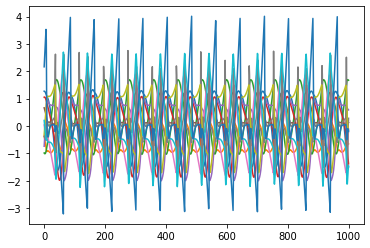

In [14]:
plt.plot(obs_n)

In [16]:
pca.singular_values_

array([66.96241703, 62.85635603, 32.12415548, 20.19226869, 13.24677259,
        9.62947852,  3.82649372,  2.53680784,  2.27189588,  1.84676048,
        0.99354536])

In [17]:
plt.plot(pobs)

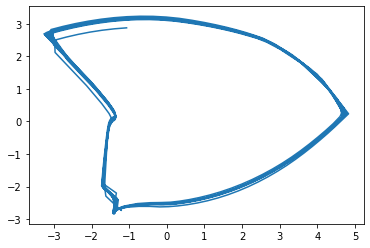

In [22]:
plt.plot(pobs[:,0], pobs[:,1])

In [ ]:
start = time.time()
keys = list(mesh.keys())[1:]
i = 0 

with Pool(12, maxtasksperchild=1000) as pool:
    for init_key in keys:    
        i+=1 
        
        init_state = mesh[init_key].state
        state_iter = repeat(init_state, n_forces)
        seeds_iter = range(i*n_forces, i*n_forces+n_forces)

        for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
            obs = res
    
            peak_idx,_ = find_peaks(obs[:,0], distance=20)

            if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
                new_id = fail_id
                mesh[fail_state].freq +=1
            else:
                new_key = ((obs[peak_idx,:] - np.array(policy.state_means))/np.array(policy.state_std)).squeeze()
                if new_key in mesh:
                    new_id = mesh[new_key].id
                    mesh[new_key].freq += 1
                else:
                    mesh[new_key] = MeshBox(obs[peak_idx, :].squeeze(), len(mesh), 1, [])
                    new_id = len(mesh)-1
                    keys.append(mesh.__keytransform__(new_key))
            
            mesh[init_key].trans_list.append(new_id)
                        
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

# Construct and Populate Transition Matrix

In [ ]:
print(mesh)

In [ ]:
from scipy.sparse import lil_matrix
T = lil_matrix((len(mesh), len(mesh)))

T[0,0] = 1
for box in mesh.values():
    for trans_id in box.trans_list:
        T[box.id, trans_id] += 1/len(box.trans_list)

In [ ]:
#plt.spy(T, markersize=4, figsize=(15,20))
fig, ax = plt.subplots(1, figsize=(15,15))
ax.spy(T, markersize=1)

In [ ]:
from scipy.sparse.linalg import eigs
w, v = eigs(T.conjugate())
print(w)

print(-1/np.log(w[1]))

In [ ]:
import dill
with  open("meshes_f2/mdim0_noise_01.pkl", 'wb') as file:
  dill.dump(mesh, file)

In [ ]:
import dill
#with 
mdim_mesh = dill.load(open("meshes/hopper0_mdim_noise.pkl", 'rb'))
# with  open("meshes/hopper0_iden.pkl", 'wb') as file:
#   dill.dump(mdim_mesh, file)

In [ ]:
T[:,0]

In [ ]:
for m in mesh